# 0.0 IMPORTS

In [3]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler

## 0.1 Loading Data

In [4]:
path = 'C:/Users/edils/repos/pa004_health_insurance/data/'

In [5]:
df_raw = pd.read_csv(path + 'train.csv')

## 0.2 Helper Functions

In [6]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# 1.0 DATA DESCRIPTION

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = df1.columns

cols_new = []
cols_new = cols_old.map(lambda x: inflection.underscore(x))

df1.columns = cols_new

## 1.2 Data Dimension

In [9]:
df1.shape

(381109, 12)

## 1.3 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA 

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Descriptive Statistics

In [12]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1 Numerical Attributes

In [13]:
#Dispersion - std, min, max, range, skew, kurtosis + #Central Tendency - mean, median
disp = numerical_attributes.agg(['std','mean','median','min','max',lambda x: x.max()-x.min(),'skew','kurtosis']).T.reset_index()
disp = disp.rename(columns={'index': 'attributes', '<lambda>': 'range'})

In [14]:
disp

,attributes,std,mean,median,min,max,range,skew,kurtosis
0,id,110016.836208,190555.000000,190555.0,1.0,381109.0,381108.0,9.443274e-16,-1.200000
1,age,15.511611,38.822584,36.0,20.0,85.0,65.0,6.725390e-01,-0.565655
2,driving_license,0.046110,0.997869,1.0,0.0,1.0,1.0,-2.159518e+01,464.354302
3,region_code,13.229888,26.388807,28.0,0.0,52.0,52.0,-1.152664e-01,-0.867857
4,previously_insured,0.498251,0.458210,0.0,0.0,1.0,1.0,1.677471e-01,-1.971871
5,annual_premium,17213.155057,30564.389581,31669.0,2630.0,540165.0,537535.0,1.766087e+00,34.004569
6,policy_sales_channel,54.203995,112.034295,133.0,1.0,163.0,162.0,-9.000081e-01,-0.970810
7,vintage,83.671304,154.347397,154.0,10.0,299.0,289.0,3.029517e-03,-1.200688
8,response,0.327936,0.122563,0.0,0.0,1.0,1.0,2.301906e+00,3.298788


### 1.5.2 Categorical Attributes

In [15]:
categorical_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='vehicle_damage', ylabel='response'>

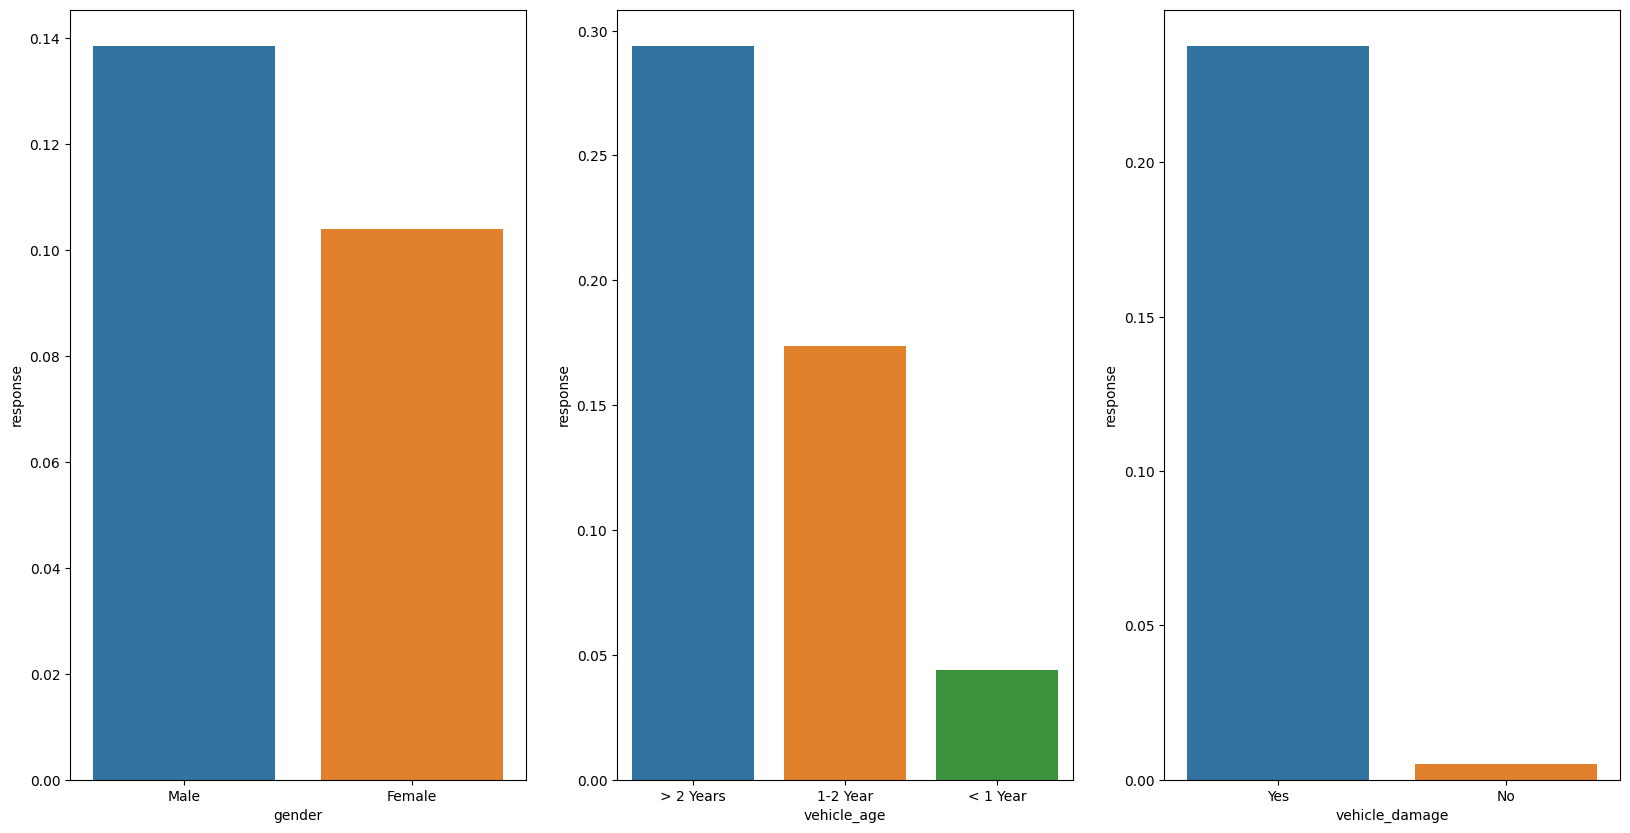

In [16]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df1, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df1, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df1, errorbar=None)


# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis

1. Pessoas que já possuem um seguro de saúde podem estar mais inclinadas a adquirir um seguro de veículo, pois já têm experiência com seguros.
2. Clientes que possuem um histórico de acidentes de carro podem estar mais interessados em um seguro de veículo.
3. Clientes que possuem um carro mais novo são mais prováveis de adquirirem o seguro.
4. A idade do cliente pode ser um fator importante, com os clientes mais jovens sendo menos propensos a adquirir um seguro de veículo.
5. A localização geográfica dos clientes pode ser um fator importante, com as pessoas que moram em áreas com altos índices de roubos de veículos sendo mais propensas a adquirir um seguro de veículo.
6. O gênero do cliente pode ser um fator, com homens sendo mais propensos a adquirir um seguro de veículo.
7. O preço do seguro de veículo pode ser um fator importante, com clientes mais propensos a adquirir um seguro de veículo se os preços estiverem competitivos.
8. Clientes com CNH são mais propensos a adquirirem o seguro.

## 2.2 Feature Engineering

In [17]:
df2 = df1.copy()

In [18]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [19]:
#Renaming vehicle_age lines
#< 1 Year = new || 1-2 Years = used || >2 Years = old
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')

#Renaming vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

#Renaming gender #Male = 1, Female = 0
df2['gender'] = df2['gender'].apply(lambda x: 1 if x=='Male' else 0)

In [20]:
    df2.sample(15).T

,13630,58912,340250,317699,288038,19424,170456,212658,159817,183598,128575,370077,368838,281992,149531
id,13631,58913,340251,317700,288039,19425,170457,212659,159818,183599,128576,370078,368839,281993,149532
gender,0,0,0,1,0,0,1,1,1,1,0,0,0,1,0
age,45,21,24,41,21,43,23,46,22,64,30,21,26,21,24
driving_license,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
region_code,28.0,13.0,28.0,3.0,8.0,29.0,10.0,35.0,41.0,46.0,8.0,11.0,2.0,27.0,10.0
previously_insured,1,1,1,0,1,0,1,1,1,0,0,0,1,0,0
vehicle_age,used,new,new,used,new,used,new,used,new,old,new,new,new,new,new
vehicle_damage,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1
annual_premium,31686.0,23666.0,51717.0,2630.0,43117.0,2630.0,38765.0,24847.0,25957.0,2630.0,37893.0,30727.0,2630.0,25140.0,26822.0
policy_sales_channel,26.0,152.0,152.0,157.0,160.0,26.0,152.0,124.0,152.0,26.0,152.0,152.0,1.0,160.0,152.0


# 3.0 VARIABLE FILTERING

In [21]:
df3 = df2.copy()

In [22]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,1,44,1,28.0,0,old,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,used,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,old,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,new,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,new,0,27496.0,152.0,39,0


In [23]:
df3 = df3.drop(columns=['id'])

# 4.0 EXPLORATORY DATA ANALYSIS

In [24]:
df4 = df3.copy()

In [25]:
df4.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,44,1,28.0,0,old,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,used,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,old,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,new,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,new,0,27496.0,152.0,39,0


## 4.1 Unilateral Analysis

### 4.1.1 Numerical Variables

C:\Users\edils\AppData\Local\Temp\ipykernel_16852\2996909662.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numerical_attributes.hist(ax = ax, bins=25);


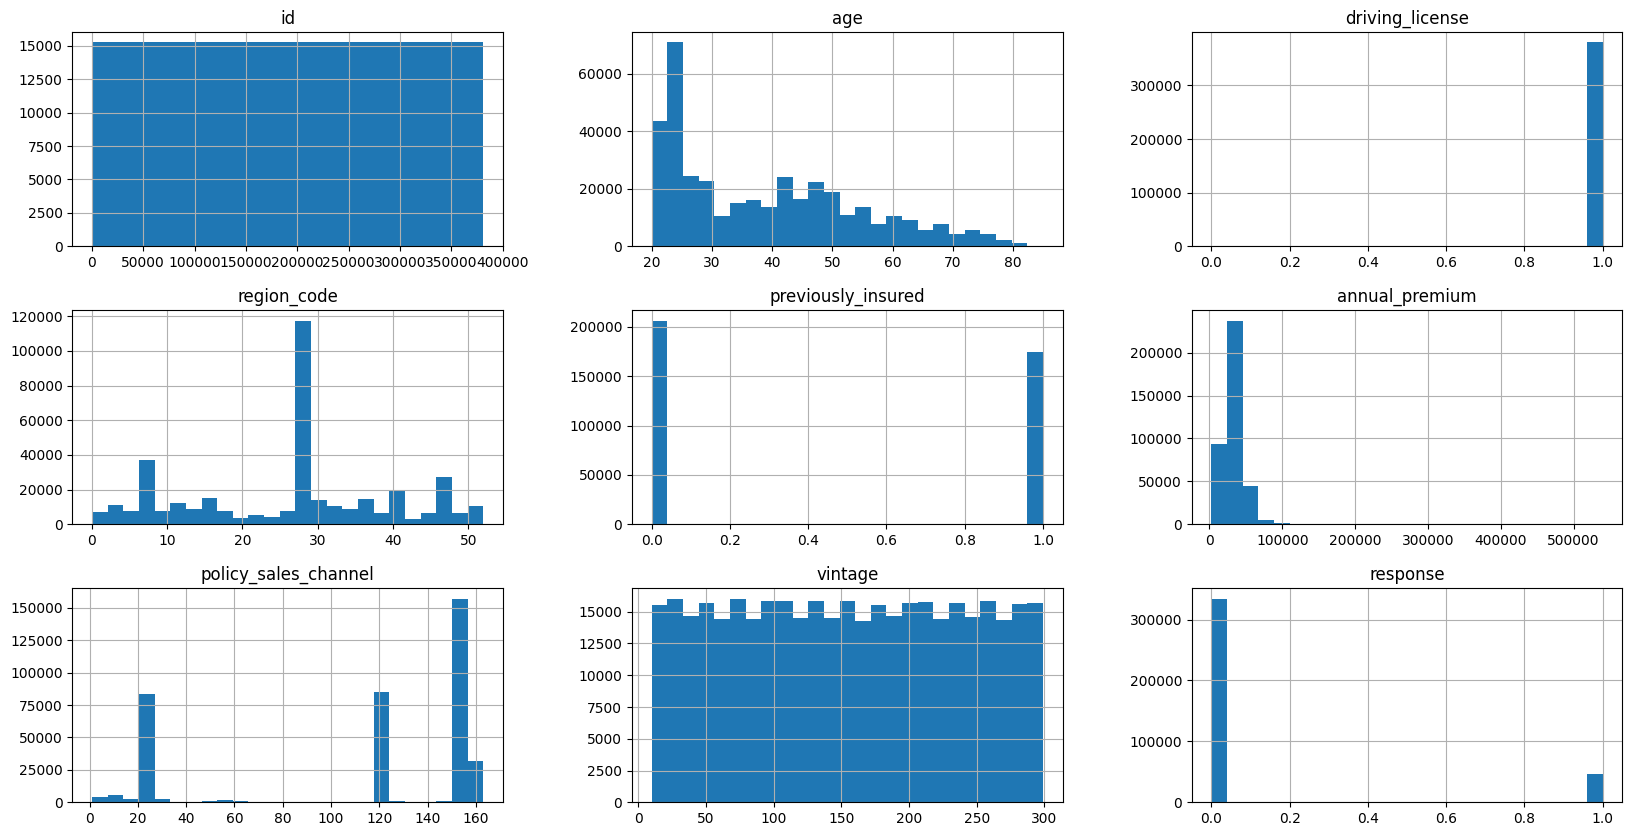

In [26]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes.hist(ax = ax, bins=25);

### 4.1.2 Categorical Variables

In [27]:
categorical_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='vehicle_damage', ylabel='count'>

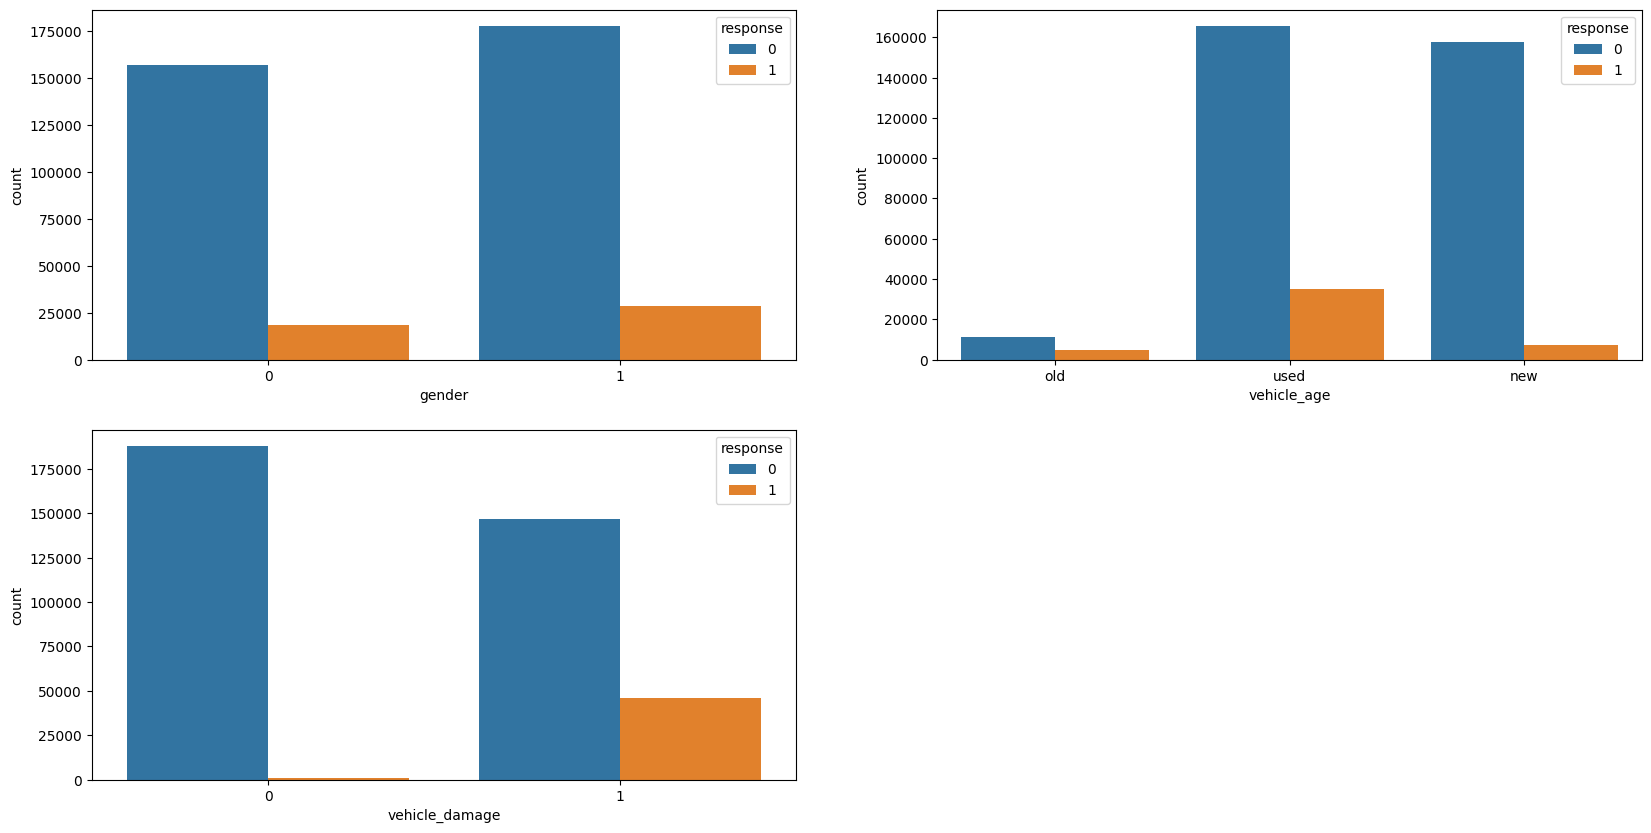

In [28]:
plt.figure(figsize=(20,10))

#gender
plt.subplot(2,2,1)
sns.countplot(data=df4, x='gender', hue='response')

#vehicle_age
plt.subplot(2,2,2)
sns.countplot(data=df4, x='vehicle_age', hue='response')

#vehicle_damage
plt.subplot(2,2,3)
sns.countplot(data=df4, x='vehicle_damage', hue='response')


## 4.2 Bilateral Analysis

### 4.2.1 H1 - Pessoas que já possuem um seguro de saúde podem estar mais inclinadas a adquirir um seguro de veículo, pois já têm experiência com seguros.

<Axes: xlabel='vintage', ylabel='Count'>

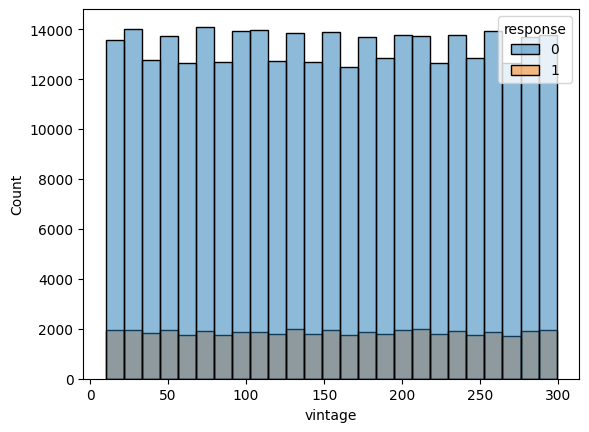

In [29]:
#Vintage
sns.histplot(x='vintage', hue='response', bins=25, data=df4)

 H1 - FALSO. Podemos ver que não há muita diferença nas barras laranjas se o cliente está com pouco dias <50 ou muito dias >250

### 4.2.2 H2 - Clientes que possuem um histórico de acidentes de carro podem estar mais interessados em um seguro de veículo.

<Axes: xlabel='vehicle_damage', ylabel='count'>

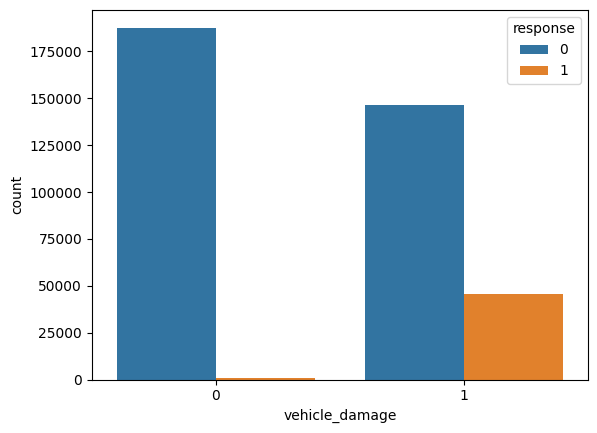

In [30]:
sns.countplot(data=df4, x='vehicle_damage', hue='response')

H2 - VERDADEIRO - Podemos ver que clientes que já tiveram defeito no carro no passado tendem a querer o seguro mais do que os que não tiveram

### 4.2.3 H3 - Clientes que possuem um carro mais novo são mais prováveis de adquirirem o seguro.

<Axes: xlabel='vehicle_age', ylabel='count'>

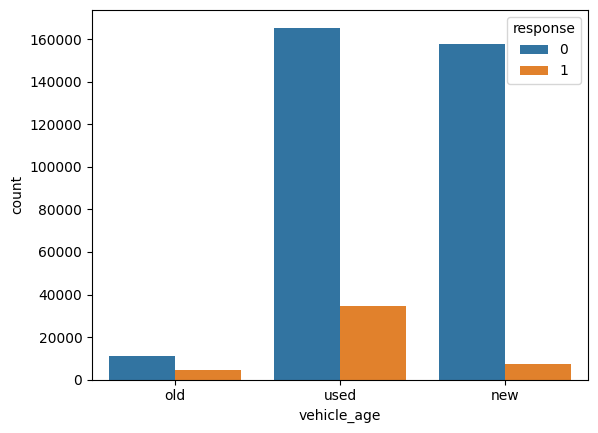

In [31]:
sns.countplot(data=df4, x='vehicle_age', hue='response')

H3 - FALSO - Clientes que possuem carros USADOS (entre 1 e 2 anos) são os que tendem a querer o seguro.

### 4.2.4 H4 - A idade do cliente pode ser um fator importante, com os clientes mais jovens sendo menos propensos a adquirir um seguro de veículo.

Text(0.5, 1.0, 'Idade Apenas dos que querem o seguro')

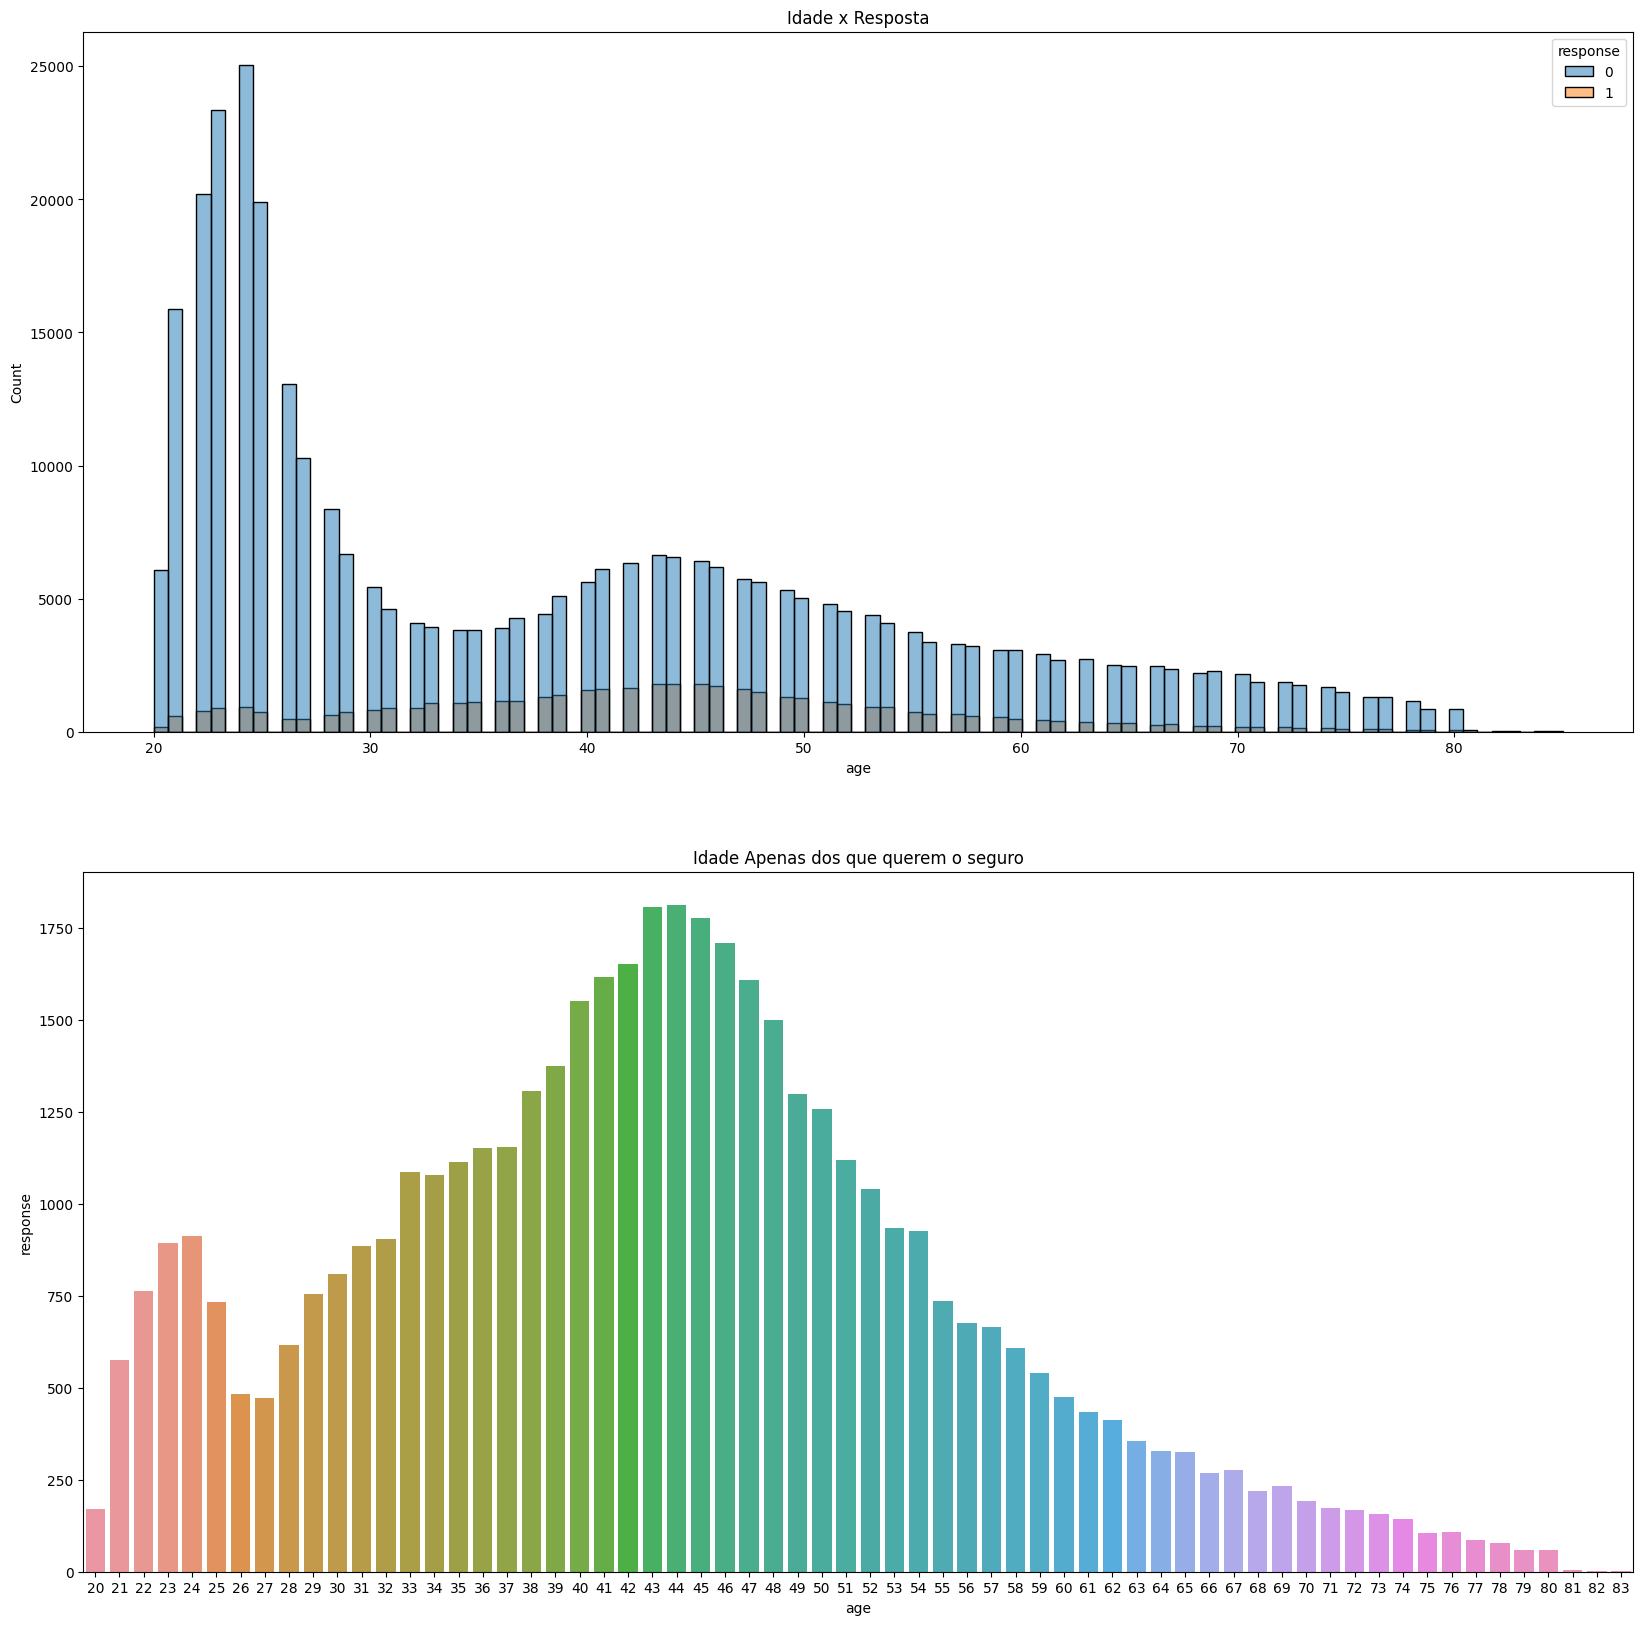

In [32]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.histplot(x='age', hue='response', data=df4)
plt.title("Idade x Resposta")

plt.subplot(2,1,2)
aux = df4.loc[df4['response'] == 1,['response','age']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux)
plt.title("Idade Apenas dos que querem o seguro")

H4 - VERDADEIRO - Os clientes entre a faixa de 40 e 50 são os mais propensos a adquirir o seguro

### 4.2.5 H5 - A localização geográfica dos clientes pode ser um fator importante, com as pessoas que moram em áreas com altos índices de roubos de veículos sendo mais propensas a adquirir um seguro de veículo.

<Axes: xlabel='region_code', ylabel='response'>

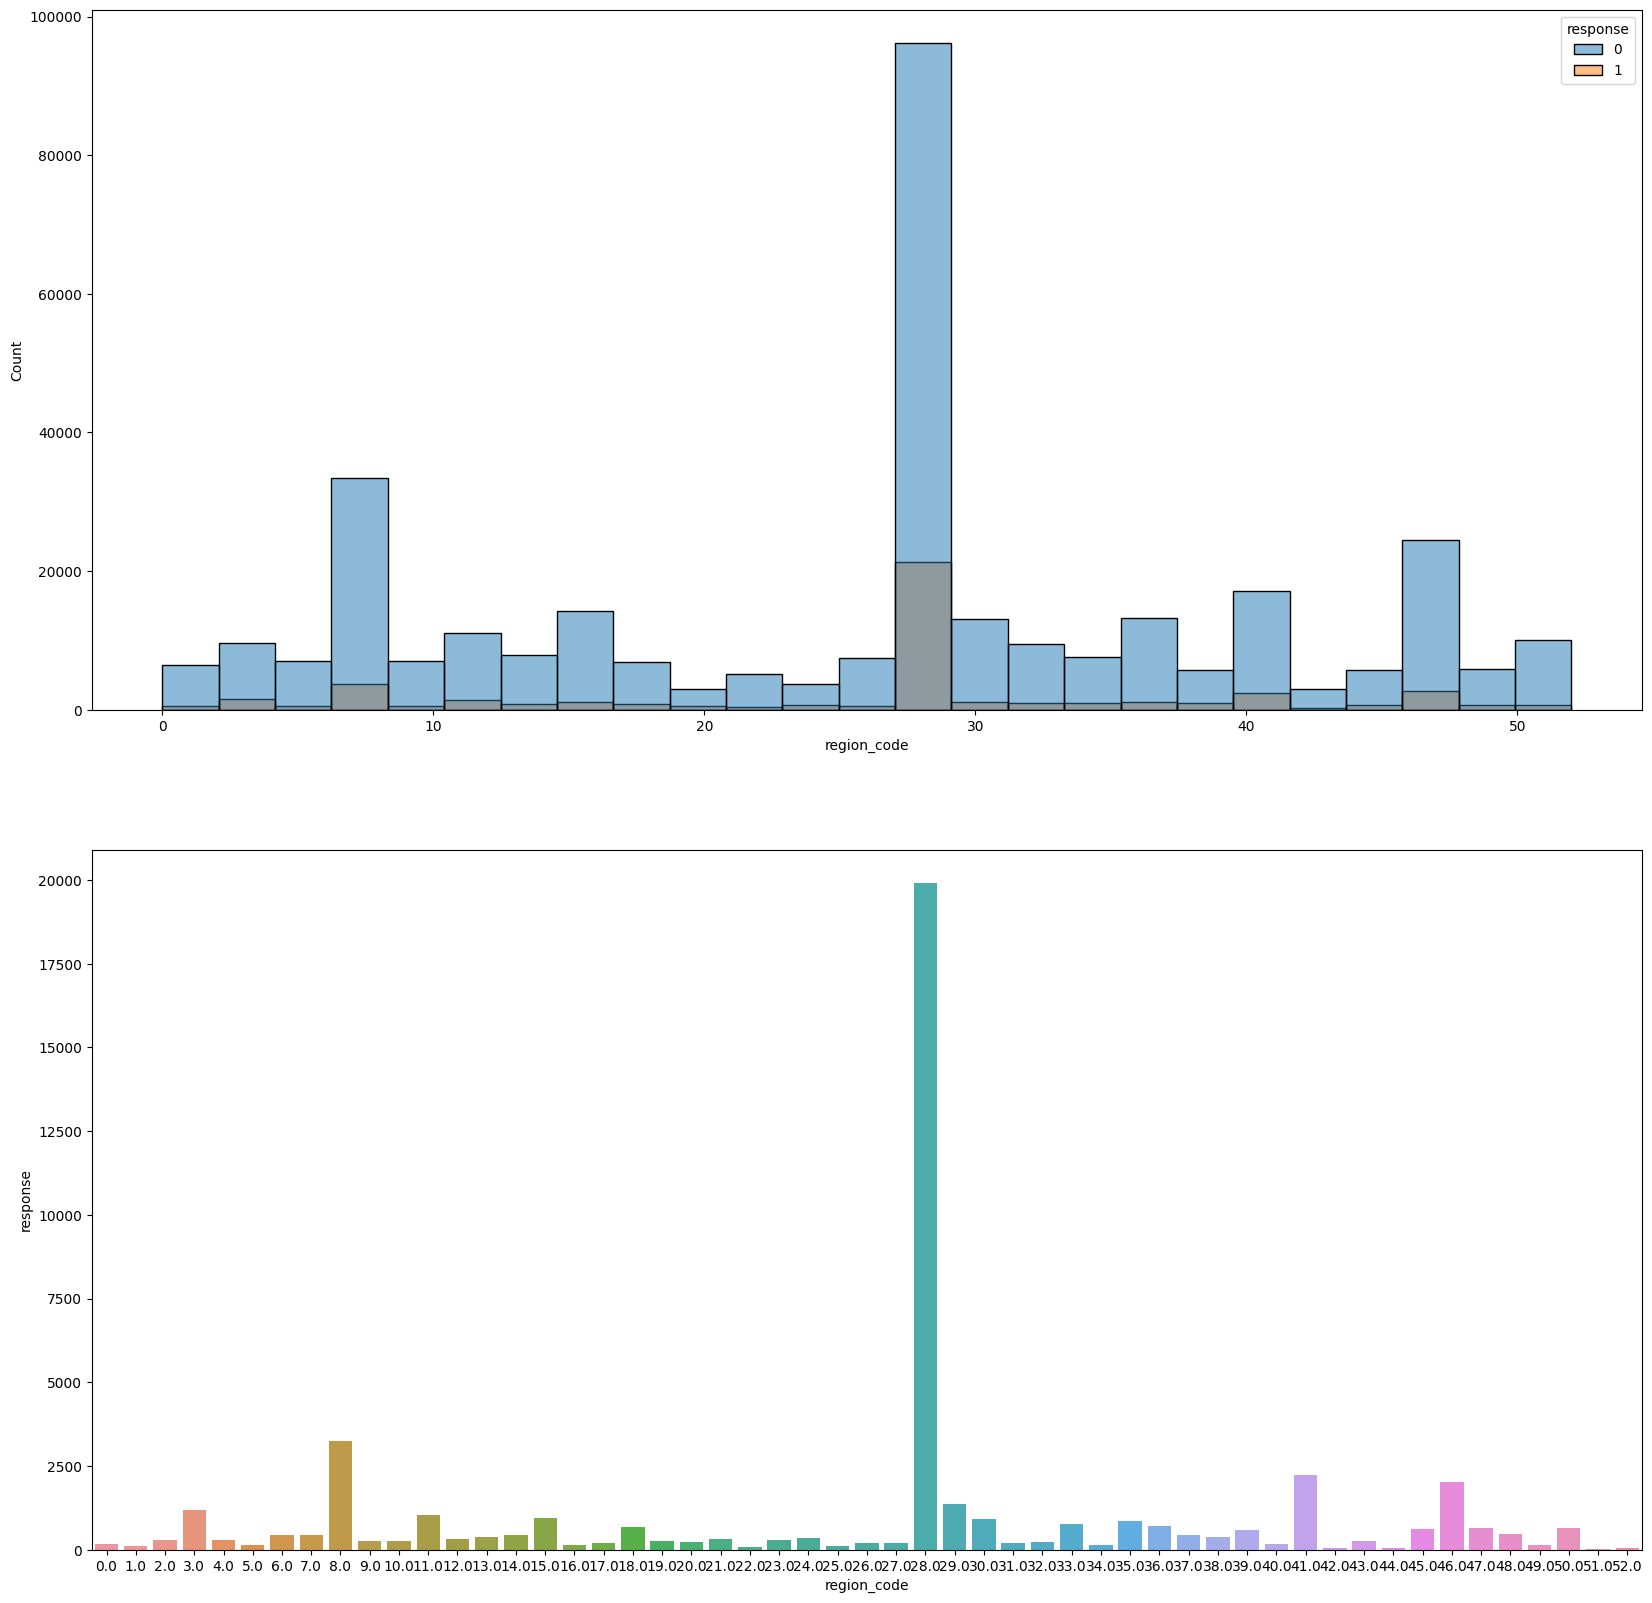

In [33]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.histplot(x='region_code', hue='response', data=df4, bins=25)

plt.subplot(2,1,2)
aux = df4.loc[df4['response'] == 1,['response','region_code']].groupby('region_code').sum().reset_index()
sns.barplot(x='region_code', y='response', data=aux)

VERDADEIRO - Podemos ver que na região 028 temos muito mais clientes interessados em adquirir o seguro.

### 4.2.6 H6 - O gênero do cliente pode ser um fator, com homens sendo mais propensos a adquirir um seguro de veículo.

<Axes: xlabel='gender', ylabel='Count'>

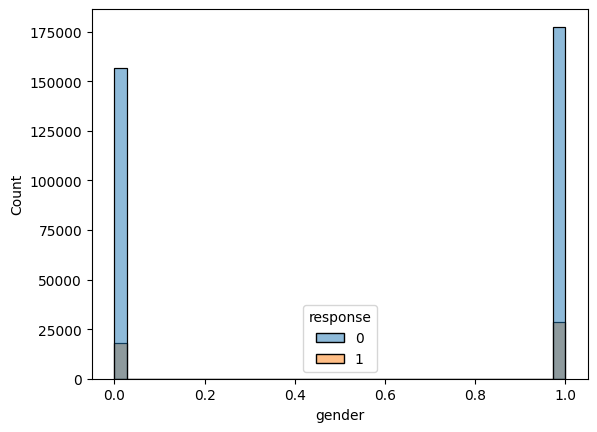

In [34]:
sns.histplot(x='gender', hue='response', data=df4)

VERDADEIRO - Podemos ver pelas barras laranjas que, dos que têm interesse no seguro, a maioria são homens.

### 4.2.7 H7 - O preço do seguro de veículo pode ser um fator importante, com clientes mais propensos a adquirir um seguro de veículo se os preços estiverem competitivos.

<Axes: xlabel='annual_premium', ylabel='Count'>

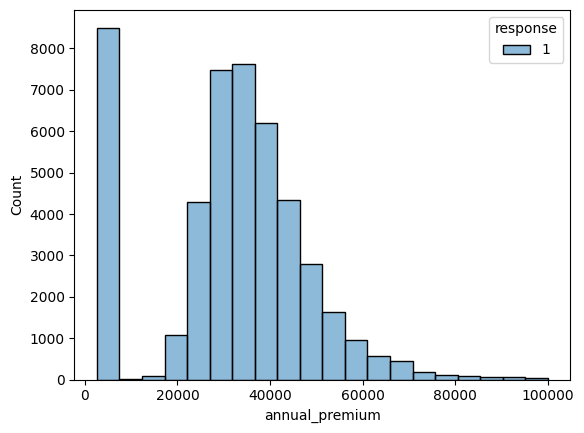

In [35]:
aux1 = df4.loc[(df4['response'] == 1) & (df4['annual_premium'] < 100000),['annual_premium','response']]
sns.histplot(x='annual_premium', hue='response', data=aux1, bins=20)

VERDADEIRO - A maioria dos clientes que gostariam de adquirir o seguro seria no valor de 2630. Depois o pico aparece em torno dos 40.000. Provavelmente esse seguro de 2630 seja o mais barato com algumas vantagens e depois o de 40.000 ofereça vantagens mais robustas.

### 4.2.8 H8 - Clientes com CNH são mais propensos a adquirirem o seguro.

<Axes: xlabel='driving_license', ylabel='Count'>

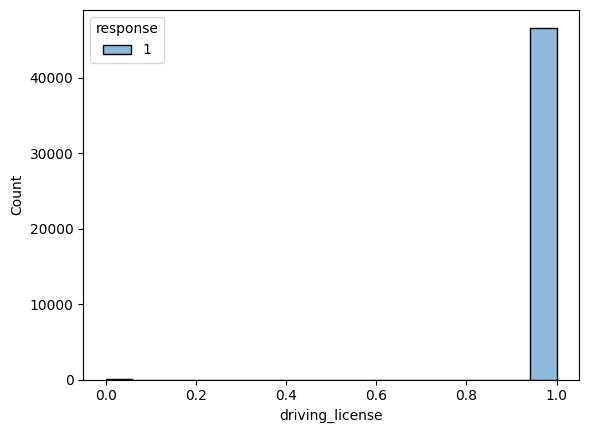

In [36]:
aux1 = df4.loc[df4['response'] == 1,['driving_license','response']]
sns.histplot(x='driving_license', hue='response', data=aux1)

VERDADEIRO - A maioria dos clientes que querem o seguro possuem CNH.

### 4.2.9 - H9 - Pessoas que já tinham seguros anteriormente tendem a querer o seguro, pois já têm experiência.

<Axes: xlabel='previously_insured', ylabel='Count'>

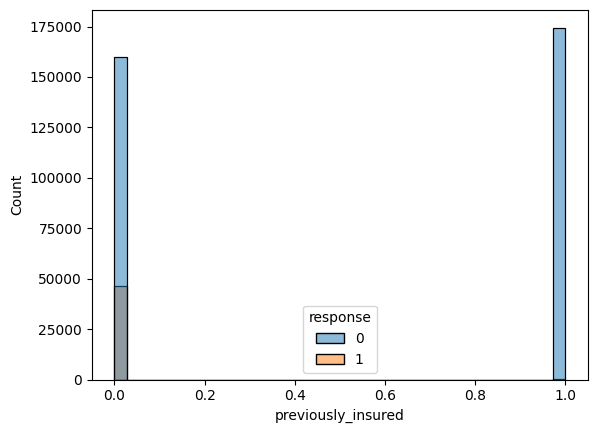

In [37]:
sns.histplot(x='previously_insured', hue='response', data=df4)

FALSO - Praticamente todas as pessoas que já tinham seguro anteriormente não querem o novo seguro.

### 4.2.10 - H10 - Pessoas que são notificadas por algum meio específico(ex: telefone) podem tender a querer o seguro

<Axes: xlabel='policy_sales_channel', ylabel='Count'>

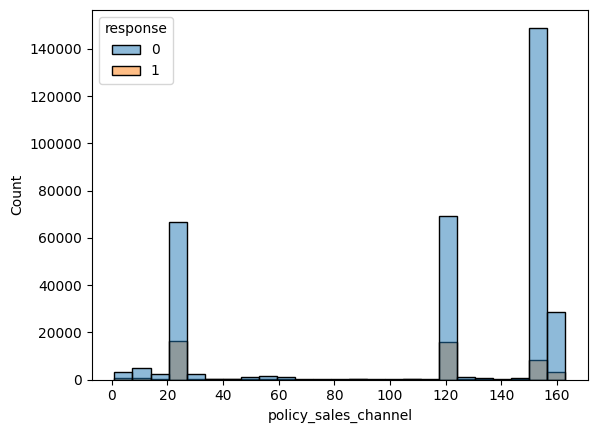

In [38]:
sns.histplot(x='policy_sales_channel', hue='response', data=df4, bins=25)

VERDADEIRO - Existem forma de contato com o cliente que facilitam eles a adquirirem o seguro.

## 4.3 Multilateral Analysis

<Axes: >

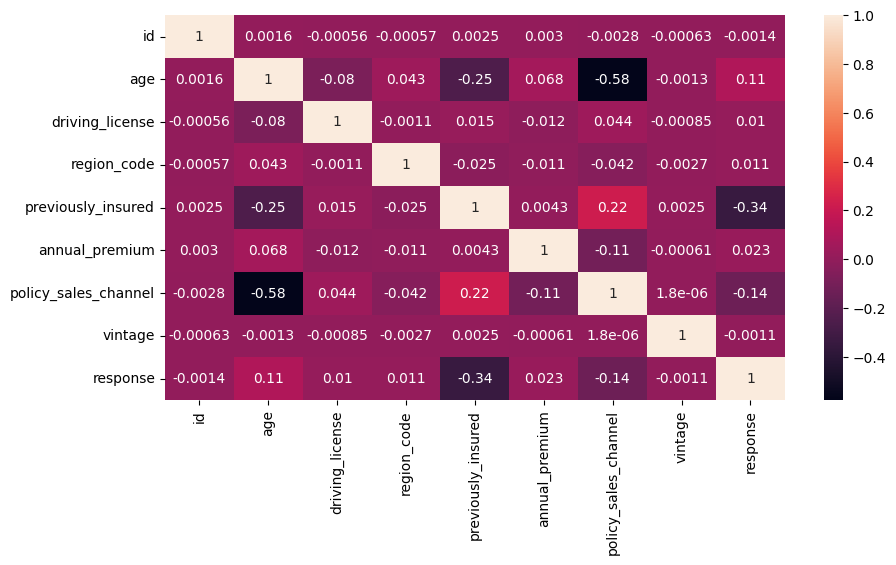

In [39]:
#Correlation Numerical Variables
plt.figure(figsize=(10,5))
sns.heatmap(numerical_attributes.corr(method='pearson'), annot=True)

In [40]:
a = categorical_attributes

<Axes: >

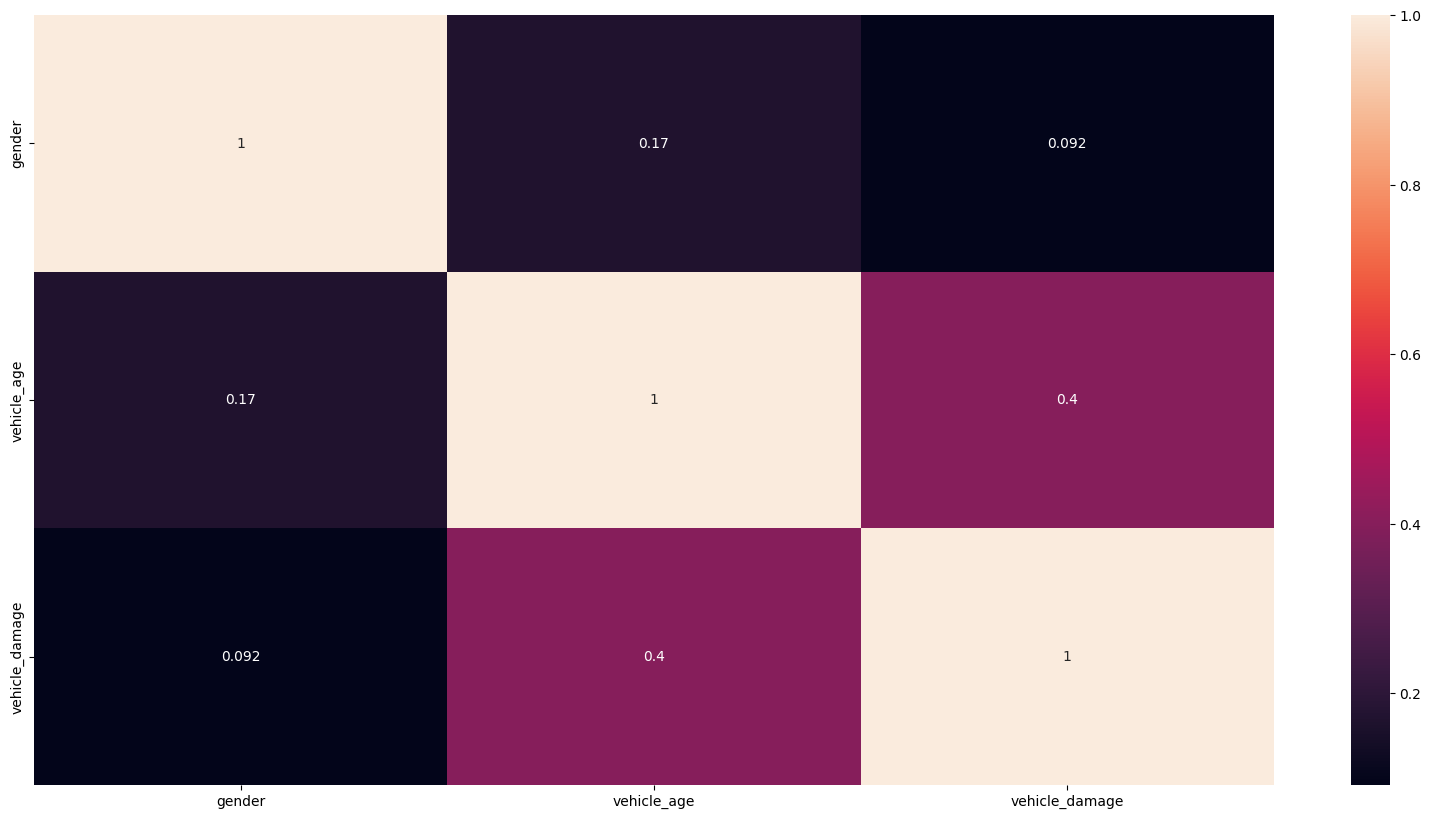

In [41]:
#Correlation Categorical Variables
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )

a4 = cramer_v( a['vehicle_age'], a['gender'] )
a5 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a6 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )

a7 = cramer_v( a['vehicle_damage'], a['gender'] )
a8 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a9 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
               'vehicle_age': [a4, a5, a6],
               'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )
plt.figure(figsize=(20,10))
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION

In [83]:
df5 = df4.copy()

In [92]:
df5.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,0.369231,1,0.279225,0,2,1,0.585862,0.209127,0.716263,1
1,1,0.861538,1,0.024274,0,1,0,0.124508,0.209127,0.598616,0
2,1,0.415385,1,0.279225,0,2,1,0.441814,0.209127,0.058824,1
3,1,0.015385,1,0.024224,1,0,0,-0.203401,0.353663,0.667820,0
4,0,0.138462,1,0.047921,1,0,0,-0.278293,0.353663,0.100346,0


## 5.1 Standardization

In [84]:
ss = StandardScaler()

## 5.2 Encoding

In [85]:
#vehicle_age - Label Encoder
df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == 'new' else 1 if x == 'used' else 2)

In [86]:
#gender - Target(mean) Enconding
#target_encoder_gender = df5.loc[:,['gender','response']].groupby('gender').mean().reset_index()
#df5['gender'] = df5['gender'].apply(lambda x: target_encoder_gender.iloc[0,1] if x == 0 else target_encoder_gender.iloc[1,1] )

In [87]:
#region_code - Frequency Encoding
fe_region_code = df5.groupby('region_code').size() / len (df5)
df5['region_code'] = df5['region_code'].apply(lambda x: fe_region_code[x])


#policy_sales_channel'
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len (df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].apply(lambda x: fe_policy_sales_channel[x])

## 5.3 Rescalling

In [89]:
mms = MinMaxScaler()
rb = RobustScaler()

#age 
df5['age'] = mms.fit_transform(df5['age'].values.reshape(-1,1))


In [90]:
#annual_premium
df5['annual_premium'] = rb.fit_transform(df5['annual_premium'].values.reshape(-1,1))

In [91]:
#vintage
df5['vintage'] = mms.fit_transform(df5['vintage'].values.reshape(-1,1))